In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import seaborn as sns
import statistics
%matplotlib inline

## 1 часть

#### Скачиваем данные

In [4]:
years = range(1880,2011)
pieces = []
columns = ['name', 'gender', 'count']
for year in years:
 path = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/datasets/babynames/yob%d.txt' % year
 frame = pd.read_csv(path, delimiter=',', names=columns)
 frame['year'] = year
 pieces.append(frame)
    
# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)    


In [5]:
names.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


#### Визуализация общей динамики рождаемости обоих полов 

In [6]:
count_gender = pd.crosstab(names['year'], names['gender'], values = names['count'], aggfunc=sum)

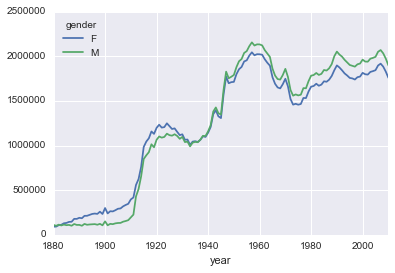

In [7]:
count_gender.plot()

#### Cамые популярные имена за всю историю

In [8]:
F_names = names[names.gender == 'F'].groupby(['name','gender']).sum()
F_names = F_names.drop(['year'], axis=1)
M_names = names[names.gender == 'M'].groupby(['name','gender']).sum()
M_names = M_names.drop(['year'], axis=1)

In [9]:
top5_F_names = F_names.sort_values(by='count', ascending=False).head()
top5_M_names = M_names.sort_values(by='count', ascending=False).head()

In [10]:
top5_F_names.append(top5_M_names)

,,count
name,gender,
Mary,F,4103935
Patricia,F,1568742
Elizabeth,F,1561874
Jennifer,F,1455078
Linda,F,1448771
James,M,5049727
John,M,5040319
Robert,M,4767995
Michael,M,4243903


#### Разбить весь временной промежуток в данных на 10 частей и для каждой найти самое популярное имя каждого пола.

In [11]:
names['group'] = 0
names.loc[(names.year >= 1880) & (names.year <= 1893), "group"] = 1
names.loc[(names.year >= 1894) & (names.year <= 1907), "group"] = 2
names.loc[(names.year >= 1908) & (names.year <= 1921), "group"] = 3
names.loc[(names.year >= 1922) & (names.year <= 1935), "group"] = 4
names.loc[(names.year >= 1936) & (names.year <= 1949), "group"] = 5
names.loc[(names.year >= 1950) & (names.year <= 1963), "group"] = 6
names.loc[(names.year >= 1964) & (names.year <= 1977), "group"] = 7
names.loc[(names.year >= 1978) & (names.year <= 1981), "group"] = 8
names.loc[(names.year >= 1982) & (names.year <= 1995), "group"] = 9
names.loc[(names.year >= 1996) & (names.year <= 2010), "group"] = 10

In [12]:
count_namegroup = names.groupby(['name','group','gender'], as_index=False).sum()
count_namegroup = count_namegroup.drop(['year'], axis=1)
count_namegroup[0:3]

,name,group,gender,count
0,Aaban,10,M,20
1,Aabid,10,M,5
2,Aabriella,10,F,5


In [13]:
count_namegroup1 = count_namegroup.drop(['name'], axis=1)
count_namegroup2 = count_namegroup1.groupby(['group','gender'], as_index=False).max()
count_namegroup2[0:3] 

,group,gender,count
0,1,F,141412
1,1,M,123220
2,2,F,204984


In [14]:
result = pd.merge(count_namegroup2,count_namegroup, on=['group', 'gender','count'], how='inner')

In [15]:
result

,group,gender,count,name
0,1,F,141412,Mary
1,1,M,123220,John
2,2,F,204984,Mary
3,2,M,113061,John
4,3,F,661462,Mary
5,3,M,510381,John
6,4,F,908386,Mary
7,4,M,823130,Robert
8,5,F,860956,Mary
9,5,M,1025087,James


In [16]:
popular_name = result[['gender','name']].drop_duplicates()
popular_name

,gender,name
0,F,Mary
1,M,John
7,M,Robert
9,M,James
11,M,Michael
12,F,Jennifer
16,F,Jessica
18,F,Emily
19,M,Jacob


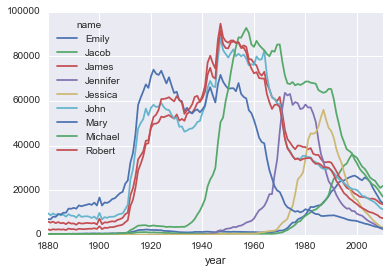

In [17]:
result_visualisation = pd.merge(popular_name,names, on=['name','gender'],how = 'left')
result_visualisation = result_visualisation.drop(['group','gender'],axis = 1)
result_visualisation = pd.crosstab( index = result_visualisation['year'],columns = result_visualisation['name'], values = result_visualisation['count'], aggfunc = max )
result_visualisation.plot()

#### Сколько имен покрывают 50% людей в каждом году

Расчитаем пропорцию имени к общему количеству имен в году

In [18]:
def add_prop(group):
 # Integer division floors
 count =  group['count'].astype(float)
 group['prop'] = count/count.sum()
 return group
names = names.groupby(['year', 'gender']).apply(add_prop)

Находим сколько имен покрывают 50% людей

In [19]:
def get_quantile_count(group, q=0.5):
 group = group.sort_values(by='prop', ascending=False)
 return group.prop.cumsum().searchsorted(q) + 1
diversity = names.groupby(['year', 'gender']).apply(get_quantile_count)
diversity = diversity.unstack('gender')

In [20]:
diversity[0:5]

gender,F,M
year,,
1880,[38],[14]
1881,[38],[14]
1882,[38],[15]
1883,[39],[15]
1884,[39],[16]


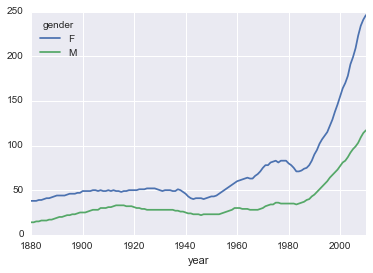

In [21]:
diversity.F = diversity.F.astype(int)
diversity.M = diversity.M.astype(int)
diversity.plot()

Имена девушек всегда были более разнообразными, чем имена мальчиков и с течением времени это разнообразие растет.

#### Распределение по первой и по последней букве в имени

по последней букве

In [22]:
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'
last_table = names.pivot_table('count', last_letters, columns=['gender', 'year'], aggfunc=sum)

по первой букве

In [23]:
get_first_letter = lambda x: x[1]
first_letters = names.name.map(get_first_letter)
first_letters.name = 'first_letter'
first_table = names.pivot_table('count', first_letters, columns=['gender', 'year'], aggfunc=sum)

выбираем 4 года

In [24]:
sub_last_table = last_table.reindex(columns=[1920, 1960, 1980, 2010], level='year')
sub_first_table = first_table.reindex(columns=[1920, 1960, 1980, 2010], level='year')

Вычисляем новые таблицы с пропорцями от всех имен для каждого пола, заканчивающегося/начинающегося на каждую букву:

In [25]:
last_letter_prop = sub_last_table / sub_last_table.sum().astype(float)
first_letter_prop = sub_first_table / sub_first_table.sum().astype(float)

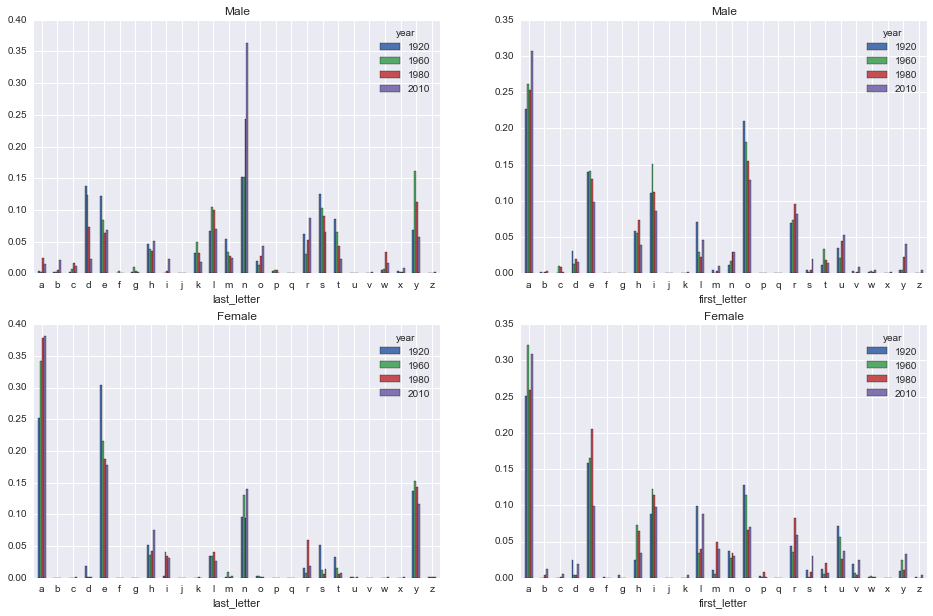

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
last_letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0][0], title='Male')
last_letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1][0], title='Female')
first_letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0][1], title='Male')
first_letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1][1], title='Female')

Вывод: Чаще всего мужские имена начинаются на 'a' и заканчиваются на 'n', женские и начинаются и заканчиваются на 'a'

#### Влияние знаменитостей на динамику имен

Список знаменитостей :
Charles Chaplin - born 1889 - 1929,
Audrey Hepburn - born 1929 - 1950-1970,
Marilyn Monroe - born 1926 - 1950-1970

In [27]:
sub_names = names[(names.name == 'Charles')|(names.name == 'Audrey')|(names.name == 'Marilyn')]

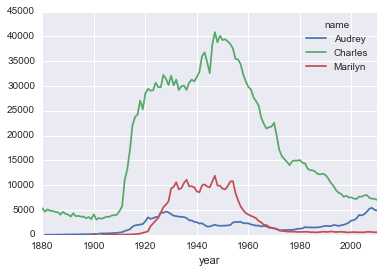

In [28]:
count_name = pd.crosstab(sub_names['year'], sub_names['name'], values = sub_names['count'], aggfunc=sum)
count_name.plot()

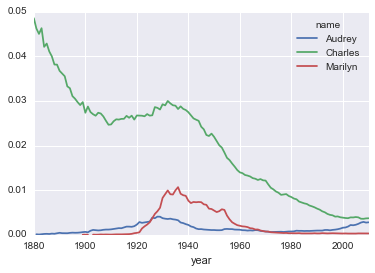

In [29]:
prop_name = pd.crosstab(sub_names['year'], sub_names['name'], values = sub_names['prop'], aggfunc=sum)
prop_name.plot()

Вывод: Charles Chaplin вполне возможно повлиял на небольшой скачек в 30х годах, Marilyn Monroe и Audrey Hepburn не оказали влияние на динамику имен. 

## 2 часть

#### Анализ активности пользователей 
yearmonth = год/месяц, year - год, month - месяц, n_visit - количество активных дней в месяц, user_id - пользователь

In [30]:
df = pd.read_csv('user_activity.csv', sep = ',',low_memory=False)
df.head()

,Unnamed: 0,yearmonth,year,month,n_visit,user_id
0,0,201604,2016,4,26,42744
1,1,201607,2016,7,30,42744
2,2,201606,2016,6,28,42744
3,3,201605,2016,5,31,42744
4,4,201603,2016,3,25,42744


In [31]:
df = df.drop('Unnamed: 0', axis = 1)

In [32]:
# рассчитываем первый месяц активности
df.set_index('user_id', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['yearmonth'].min()
df.reset_index(inplace=True)
df.head()

,user_id,yearmonth,year,month,n_visit,CohortGroup
0,42744,201604,2016,4,26,201603
1,42744,201607,2016,7,30,201603
2,42744,201606,2016,6,28,201603
3,42744,201605,2016,5,31,201603
4,42744,201603,2016,3,25,201603


In [33]:
df['Cyear'] = df['CohortGroup'].astype('str')
df['Cyear'] = df['Cyear'].str[0:4].astype('int')
df['Cmonth'] = df['CohortGroup'].astype('str')
df['Cmonth'] = df['Cmonth'].str[4:6].astype('int')
df[:5]

,user_id,yearmonth,year,month,n_visit,CohortGroup,Cyear,Cmonth
0,42744,201604,2016,4,26,201603,2016,3
1,42744,201607,2016,7,30,201603,2016,3
2,42744,201606,2016,6,28,201603,2016,3
3,42744,201605,2016,5,31,201603,2016,3
4,42744,201603,2016,3,25,201603,2016,3


In [34]:
# рассчитываем номер последующих активных месяцев для каждого пользователя
df['CohortPeriod'] = (df['month'] - df['Cmonth']) + 12*(df['year'] - df['Cyear']) + 1
df[:5]

,user_id,yearmonth,year,month,n_visit,CohortGroup,Cyear,Cmonth,CohortPeriod
0,42744,201604,2016,4,26,201603,2016,3,2
1,42744,201607,2016,7,30,201603,2016,3,5
2,42744,201606,2016,6,28,201603,2016,3,4
3,42744,201605,2016,5,31,201603,2016,3,3
4,42744,201603,2016,3,25,201603,2016,3,1


In [35]:
grouped = df.groupby(['CohortGroup', 'yearmonth', 'CohortPeriod'])
# подсчет уникальных пользователей и посещений за период в когорте
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'n_visit': np.sum,
                    })

cohorts.rename(columns={'user_id': 'TotalUsers',
                        'n_visit': 'Totalvisit'}, inplace=True)
cohorts[0:30]

Totalvisit  TotalUsers
CohortGroup yearmonth CohortPeriod                        
201503      201503    1                  34540        7226
            201504    2                  26969        3737
            201505    3                  25766        3335
            201506    4                  23811        3071
            201507    5                  21125        2585
            201508    6                  18072        2357
            201509    7                  18537        2303
            201510    8                  18785        2258
            201511    9                  17828        2118
            201512    10                 16568        2061
            201601    11                 16915        2072
            201602    12                 16975        2041
            201603    13                 17394        2003
            201604    14                 16321        1902
            201605    15                 16343        1900
            201606    16                 15313        1793
            201607    17                 14215        1699
201504      201504    1                   7753        4520
            201505    2                   5516        1225
            201506    3                   4509         957
            201507    4                   3612         700
            201508    5                   3269         605
            201509    6                   3325         618
            201510    7                   3413         598
            201511    8                   3445         548
            201512    9                   3102         531
            201601    10                  3348         582
            201602    11                  3398         576
            201603    12                  3519         543
            201604    13                  3099         552

In [36]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# общий размер каждой когорты
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
201503    7226
201504    4520
201505    4715
201506    3462
201507    1886
Name: TotalUsers, dtype: int64

In [37]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
201503       1               7226
             2               3737
             3               3335
             4               3071
             5               2585
Name: TotalUsers, dtype: int64

In [38]:
# когорты в привычном виде абсолютные значения
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607
CohortPeriod,,,,,,,,,,,,,,,,,
1,7226.0,4520.0,4715.0,3462.0,1886.0,1641.0,2024.0,2431.0,2376.0,2462.0,2826.0,2934.0,3262.0,2964.0,3354.0,3329.0,3025.0
2,3737.0,1225.0,1074.0,678.0,667.0,628.0,812.0,921.0,932.0,997.0,1191.0,1186.0,1361.0,1245.0,1432.0,1331.0,NaN
3,3335.0,957.0,663.0,490.0,507.0,434.0,587.0,681.0,674.0,737.0,864.0,868.0,1034.0,910.0,950.0,NaN,NaN
4,3071.0,700.0,573.0,495.0,432.0,388.0,495.0,637.0,597.0,652.0,706.0,764.0,819.0,701.0,NaN,NaN,NaN
5,2585.0,605.0,565.0,455.0,385.0,338.0,469.0,547.0,542.0,554.0,661.0,671.0,715.0,NaN,NaN,NaN,NaN


In [39]:
# когорты в процентах
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607
CohortPeriod,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0
2,0.517160,0.271018,0.227784,0.195841,0.353659,0.382693,0.401186,0.378856,0.392256,0.404955,0.421444,0.404226,0.417229,0.420040,0.426953,0.39982,NaN
3,0.461528,0.211726,0.140615,0.141537,0.268823,0.264473,0.290020,0.280132,0.283670,0.299350,0.305732,0.295842,0.316983,0.307018,0.283244,NaN,NaN
4,0.424993,0.154867,0.121527,0.142981,0.229056,0.236441,0.244565,0.262032,0.251263,0.264825,0.249823,0.260395,0.251073,0.236505,NaN,NaN,NaN
5,0.357736,0.133850,0.119830,0.131427,0.204136,0.205972,0.231719,0.225010,0.228114,0.225020,0.233900,0.228698,0.219191,NaN,NaN,NaN,NaN
6,0.326183,0.136726,0.110498,0.127383,0.194592,0.198050,0.228755,0.217606,0.210859,0.216491,0.209130,0.200068,NaN,NaN,NaN,NaN,NaN
7,0.318710,0.132301,0.106469,0.116407,0.190880,0.193784,0.210474,0.197450,0.203704,0.200244,0.185421,NaN,NaN,NaN,NaN,NaN,NaN
8,0.312483,0.121239,0.104348,0.110630,0.178155,0.184034,0.194664,0.198272,0.187710,0.179123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.293108,0.117478,0.103499,0.112652,0.165960,0.165753,0.195158,0.173591,0.174242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Следующая визуализация показывает, что во второй/третий месяц жизни 'отваливается' большая часть пользователей 

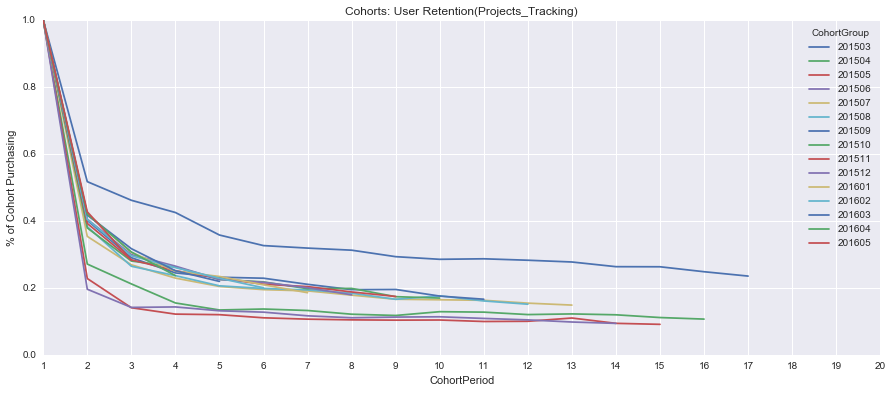

In [40]:
user_retention[[201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605]].plot(figsize=(15,6))
plt.title('Cohorts: User Retention(Projects_Tracking)')
plt.xticks(np.arange(1, 20.1, 1))
plt.xlim(1, 20)
plt.ylabel('% of Cohort Purchasing');

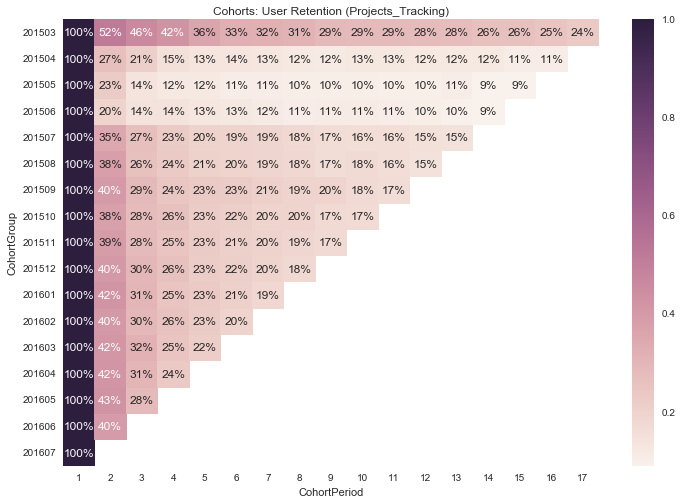

In [41]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention (Projects_Tracking)')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Примерно с пятого месяца пользователи перестают 'отваливаться', остается более менее стабильная группа пользователей, её и возьмем для исследования активности

In [47]:
fivecohort = df['CohortPeriod'] == 5
fivecoh = df[fivecohort]

Построим распределение пользователей по количеству дней в месяц

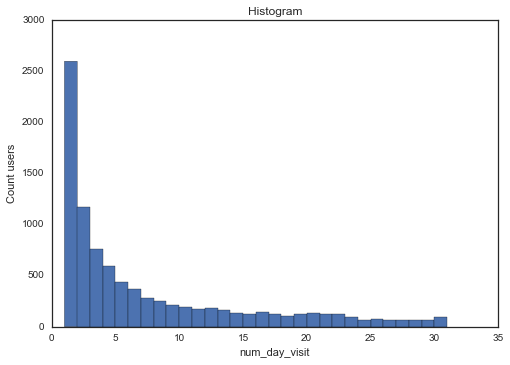

In [48]:
plt.hist(fivecoh['n_visit'],30)
plt.title("Histogram")
plt.xlabel("num_day_visit")
plt.ylabel("Count users")

fig = plt.gcf()

{'boxes': [<matplotlib.lines.Line2D at 0x127a2b470>],
 'caps': [<matplotlib.lines.Line2D at 0x127a1ef28>,
 'fliers': [<matplotlib.lines.Line2D at 0x127a29f98>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x127a29048>],
 'whiskers': [<matplotlib.lines.Line2D at 0x127a2b240>,
  <matplotlib.lines.Line2D at 0x127a1edd8>]}

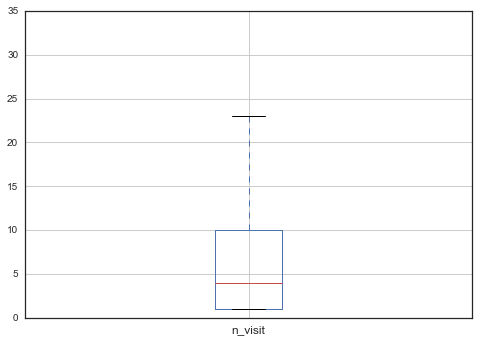

In [49]:
fivecoh.boxplot(column='n_visit',return_type = 'dict')

Вывод: Пользователя,который заходит на инструмент 4 и более дня каждый месяц можно считать активным.